In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#https://analyticsindiamag.com/a-comparison-of-4-popular-transfer-learning-models/
#https://keras.io/api/applications/efficientnet/ 
#https://vigneshgig.medium.com/xception-neural-network-transfer-learning-and-data-processing-using-ai-c3e7a4ea7bf2 

In [2]:
pip install split-folders tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import numpy as np
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
base_dir = '/content/drive/MyDrive/rice_images'

Split Dataset into 3 part: Train, Val, and Test

In [5]:
splitfolders.ratio(
    base_dir,
    output='Capstone',
    ratio=(.7,0.1,0.2)
)

Copying files: 2265 files [00:29, 77.79 files/s] 


In [6]:
train_dir = 'Capstone/train'
val_dir = 'Capstone/val' 
test_dir = 'Capstone/test'
os.listdir(train_dir)

['LeafBlast', 'BrownSpot', 'Healthy', 'Hispa']

In [7]:
class_name = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']

Data Augmentation

In [39]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=0.45,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    brightness_range=(0.5,1.0), 
                    shear_range=0.2, 
                    zoom_range=(0.8,1.0), 
                    fill_mode='nearest', 
                    horizontal_flip=True
                    )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [60]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150), 
    batch_size=45, 
    shuffle=True,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=45,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=45,
    shuffle=True,
    class_mode='categorical'
)

Found 1584 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 457 images belonging to 4 classes.


Modeling

In [61]:
from keras.callbacks import EarlyStopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=3)

In [62]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

In [63]:
from tensorflow.keras.applications import Xception
tfmodel = Xception(weights='imagenet', 
                                include_top=False, 
                                input_shape=(150,150,3))
# tfmodel.trainable = False

In [64]:
from keras.models import Sequential
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D

In [65]:
model = Sequential()
model.add(tfmodel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))      
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_34 (Dense)            (None, 512)               1049088   
                                                                 
 dense_35 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                     

In [67]:
history = model.fit(train_generator,
                    epochs=50,
                    callbacks=[monitor_val_acc,reduce_lr],
                    shuffle=True,
                    verbose=True,
                    validation_data=validation_generator)

Epoch 1/50
36/36 [==============================] - 32s 616ms/step - loss: 1.3745 - accuracy: 0.2923 - val_loss: 1.3207 - val_accuracy: 0.3527 - lr: 1.0000e-04
Epoch 2/50
36/36 [==============================] - 19s 511ms/step - loss: 1.2802 - accuracy: 0.4034 - val_loss: 1.2049 - val_accuracy: 0.4866 - lr: 1.0000e-04
Epoch 3/50
36/36 [==============================] - 19s 529ms/step - loss: 1.0963 - accuracy: 0.5366 - val_loss: 1.0914 - val_accuracy: 0.5491 - lr: 1.0000e-04
Epoch 4/50
36/36 [==============================] - 19s 524ms/step - loss: 0.9804 - accuracy: 0.5991 - val_loss: 0.9689 - val_accuracy: 0.5848 - lr: 1.0000e-04
Epoch 5/50
36/36 [==============================] - 18s 504ms/step - loss: 0.8722 - accuracy: 0.6521 - val_loss: 0.8582 - val_accuracy: 0.6696 - lr: 1.0000e-04
Epoch 6/50
36/36 [==============================] - 20s 541ms/step - loss: 0.7735 - accuracy: 0.7090 - val_loss: 0.8949 - val_accuracy: 0.6830 - lr: 1.0000e-04
Epoch 7/50
36/36 [======================

In [68]:
model.save("Model.h5")

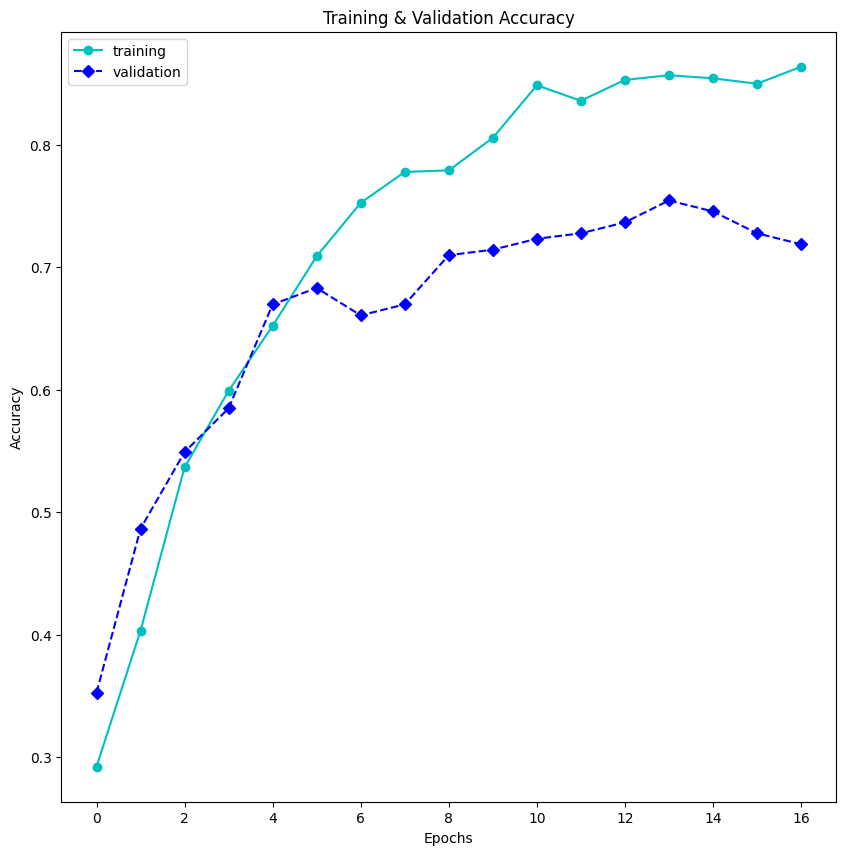

In [81]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['accuracy'])), 
         history.history['accuracy'],
         'co-',
         label='training')
plt.plot(range(len(history.history['val_accuracy'])), 
         history.history['val_accuracy'],
         'bD--',
         label='validation')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

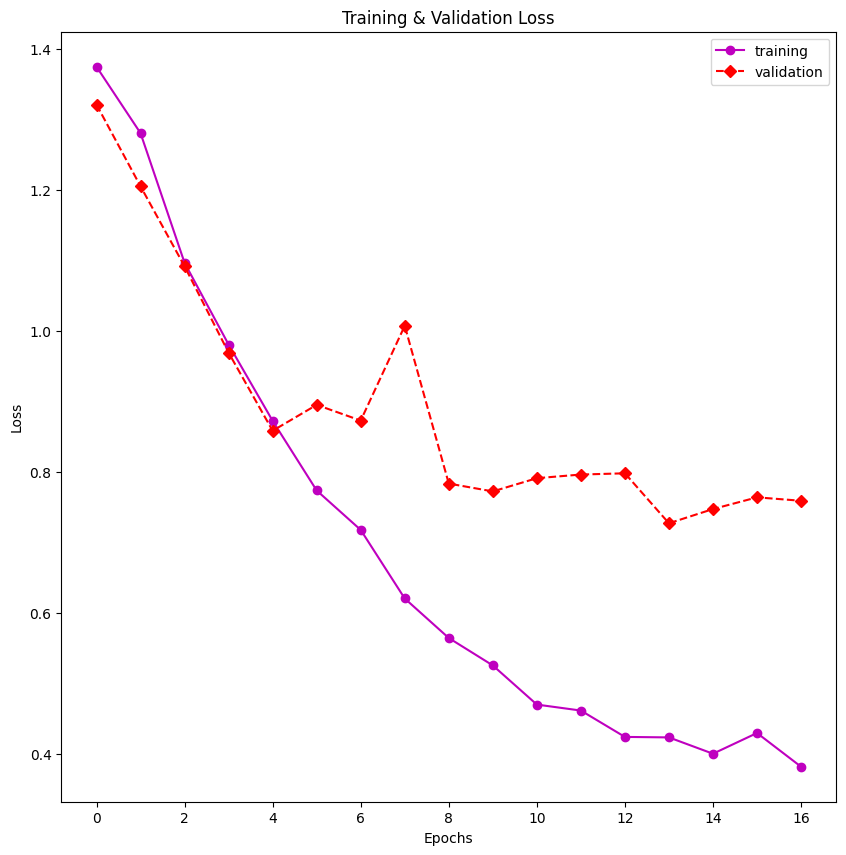

In [82]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['loss'])), 
         history.history['loss'],
         'mo-',
         label='training')
plt.plot(range(len(history.history['val_loss'])), 
         history.history['val_loss'],
         'rD--',
         label='validation')
plt.title('Training & Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [83]:
test_evaluate = model.evaluate(test_generator)

print(f'Test loss     : {test_evaluate[0]}')
print(f'Test accuracy : {round(test_evaluate[1],2)}')

11/11 [==============================] - 2s 187ms/step - loss: 0.6317 - accuracy: 0.8053
Test loss     : 0.6316861510276794
Test accuracy : 0.81


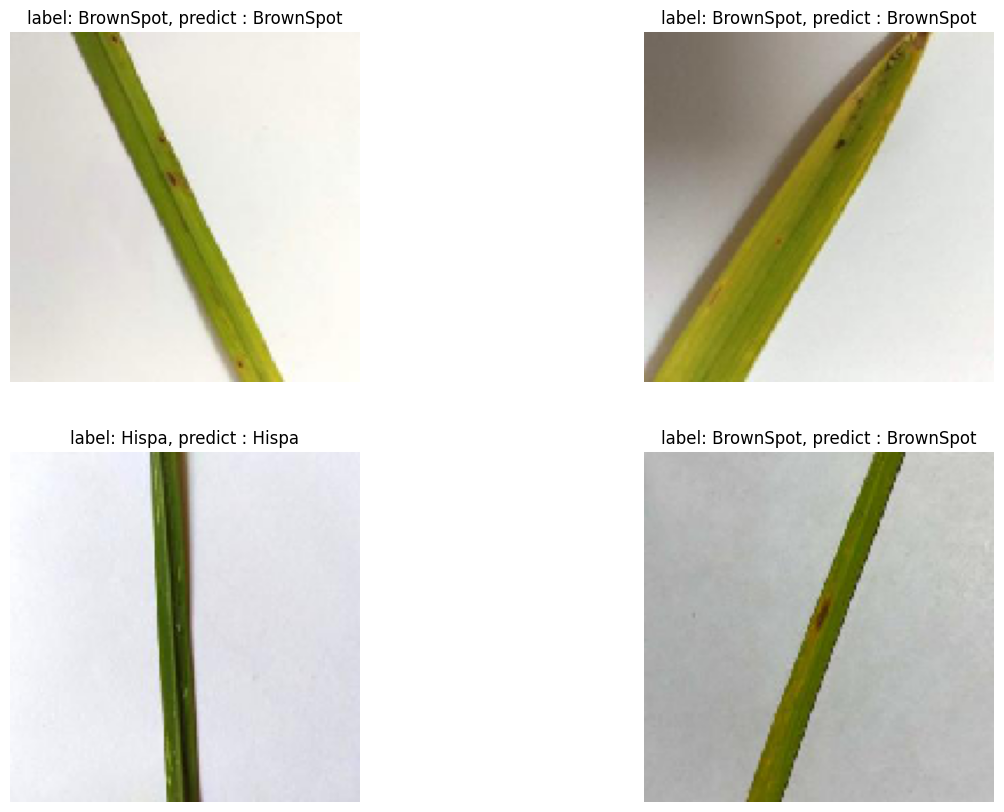

In [86]:
image ,label = next(iter(test_generator))

plt.figure(figsize=(15,10))
for i in range(4) :
    TrueLabel = class_name[np.argmax(label[i])]
    plt.subplot(2,2,i+1)
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0))
    plt.imshow(tf.squeeze(image[i]))
    plt.title(f'label: {TrueLabel}, predict : {class_name[y_pred]}')